# How to handle tool calling errors

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#tool-calling">
                    Tool calling
                </a>
            </li>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/">
                    Deleting messages
                </a>
            </li>
        </ul>
    </p>
</div> 

LLMs aren't perfect at calling tools. The model may try to call a tool that doesn't exist or fail to return arguments that match the requested schema. Strategies like keeping schemas simple, reducing the number of tools you pass at once, and having good names and descriptions can help mitigate this risk, but aren't foolproof.

This guide covers some ways to build error handling into your graphs to mitigate these failure modes.

## Setup

First, let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Setup <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how LangSmith can help you <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Using the prebuilt `ToolNode`

To start, define a mock weather tool that has some hidden restrictions on input queries. The intent here is to simulate a real-world case where a model fails to call a tool correctly:

In [3]:
from langchain_core.tools import tool


@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location == "san francisco":
        raise ValueError("Input queries must be proper nouns")
    elif location == "San Francisco":
        return "It's 60 degrees and foggy."
    else:
        raise ValueError("Invalid input.")

Next, set up a graph implementation of the [ReAct agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent). This agent takes some query as input, then repeatedly call tools until it has enough information to resolve the query. We'll use the prebuilt [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to execute called tools, and a small, fast model powered by Anthropic:

In [4]:
from typing import Literal

from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

tool_node = ToolNode([get_weather])

model_with_tools = ChatAnthropic(
    model="claude-3-haiku-20240307", temperature=0
).bind_tools([get_weather])


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

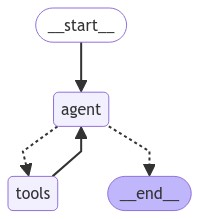

In [5]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

When you try to call the tool, you can see that the model calls the tool with a bad input, causing the tool to throw an error. The prebuilt `ToolNode` that executes the tool has some built-in error handling that captures the error and passes it back to the model so that it can try again:

In [6]:
response = app.invoke(
    {"messages": [("human", "what is the weather in san francisco?")]},
)

for message in response["messages"]:
    string_representation = f"{message.type.upper()}: {message.content}\n"
    print(string_representation)

HUMAN: what is the weather in san francisco?

AI: [{'id': 'toolu_01UagsLm5GKtdtJ6nZdADFSa', 'input': {'location': 'san francisco'}, 'name': 'get_weather', 'type': 'tool_use'}]

TOOL: Error: ValueError('Input queries must be proper nouns')
 Please fix your mistakes.

AI: [{'text': 'Apologies, it looks like there was an issue with the weather lookup. Let me try that again with the proper format:', 'type': 'text'}, {'id': 'toolu_01PwRKYxhbgW8pHnWbyubp94', 'input': {'location': 'San Francisco'}, 'name': 'get_weather', 'type': 'tool_use'}]

TOOL: It's 60 degrees and foggy.

AI: The current weather in San Francisco is 60 degrees and foggy.



## Custom strategies

This is a fine default in many cases, but there are cases where custom fallbacks may be better.

For example, the below tool requires as input a list of elements of a specific length - tricky for a small model! We'll also intentionally avoid pluralizing `topic` to trick the model into thinking it should pass a string:

In [7]:
from langchain_core.output_parsers import StrOutputParser
from langchain.pydantic_v1 import BaseModel, conlist


class HaikuRequest(BaseModel):
    topic: conlist(str, min_items=3, max_items=3)


@tool
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku


tool_node = ToolNode([master_haiku_generator])

model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)
model_with_tools = model.bind_tools([master_haiku_generator])


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

response = app.invoke(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10},
)

for message in response["messages"]:
    string_representation = f"{message.type.upper()}: {message.content}\n"
    print(string_representation)

HUMAN: Write me an incredible haiku about water.

AI: [{'text': 'Here is a haiku about water:', 'type': 'text'}, {'id': 'toolu_018KUdKbJEiprjJdBGxDs4Zq', 'input': {'topic': ['water']}, 'name': 'master_haiku_generator', 'type': 'tool_use'}]

TOOL: Error: ValidationError(model='master_haiku_generatorSchema', errors=[{'loc': ('request',), 'msg': 'field required', 'type': 'value_error.missing'}])
 Please fix your mistakes.

AI: [{'text': 'Oops, let me try that again with the required parameters:', 'type': 'text'}, {'id': 'toolu_015ENNFtemedbmJdvkzT7PU1', 'input': {'request': {'topic': ['water']}}, 'name': 'master_haiku_generator', 'type': 'tool_use'}]

TOOL: Error: ValidationError(model='master_haiku_generatorSchema', errors=[{'loc': ('request', 'topic'), 'msg': 'ensure this value has at least 3 items', 'type': 'value_error.list.min_items', 'ctx': {'limit_value': 3}}])
 Please fix your mistakes.

AI: [{'text': 'Hmm, it looks like the haiku generator requires at least 3 topics. Let me provi

We can see that the model takes two tries to get the input correct.

A better strategy might be to trim the failed attempt to reduce distraction, then fall back to a more advanced model. Here's an example. We also use a custom-built node to call our tools instead of the prebuilt `ToolNode`:

In [8]:
import json

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages.modifier import RemoveMessage


class HaikuRequest(BaseModel):
    topic: conlist(str, min_items=3, max_items=3)


@tool
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku


def call_tool(state: MessagesState):
    tools_by_name = {master_haiku_generator.name: master_haiku_generator}
    messages = state["messages"]
    last_message = messages[-1]
    output_messages = []
    for tool_call in last_message.tool_calls:
        try:
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            output_messages.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        except Exception as e:
            # Return the error if the tool call fails
            output_messages.append(
                ToolMessage(
                    content="",
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                    additional_kwargs={"error": e},
                )
            )
    return {"messages": output_messages}


model = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)
model_with_tools = model.bind_tools([master_haiku_generator])

better_model = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0)
better_model_with_tools = better_model.bind_tools([master_haiku_generator])


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def should_fallback(
    state: MessagesState,
) -> Literal["agent", "remove_failed_tool_call_attempt"]:
    messages = state["messages"]
    failed_tool_messages = [
        msg
        for msg in messages
        if isinstance(msg, ToolMessage)
        and msg.additional_kwargs.get("error") is not None
    ]
    if failed_tool_messages:
        return "remove_failed_tool_call_attempt"
    return "agent"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


def remove_failed_tool_call_attempt(state: MessagesState):
    messages = state["messages"]
    # Remove all messages from the most recent
    # instance of AIMessage onwards.
    last_ai_message_index = next(
        i
        for i, msg in reversed(list(enumerate(messages)))
        if isinstance(msg, AIMessage)
    )
    messages_to_remove = messages[last_ai_message_index:]
    return {"messages": [RemoveMessage(id=m.id) for m in messages_to_remove]}


# Fallback to a better model if a tool call fails
def call_fallback_model(state: MessagesState):
    messages = state["messages"]
    response = better_model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", call_tool)
workflow.add_node("remove_failed_tool_call_attempt", remove_failed_tool_call_attempt)
workflow.add_node("fallback_agent", call_fallback_model)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_conditional_edges("tools", should_fallback)
workflow.add_edge("remove_failed_tool_call_attempt", "fallback_agent")
workflow.add_edge("fallback_agent", "tools")

app = workflow.compile()

The `tools` node will now return `ToolMessage`s with an `error` field in `additional_kwargs` if a tool call fails. If that happens, it will go to another node that removes the failed tool messages, and has a better model retry the tool call generation.

The diagram below shows this visually:

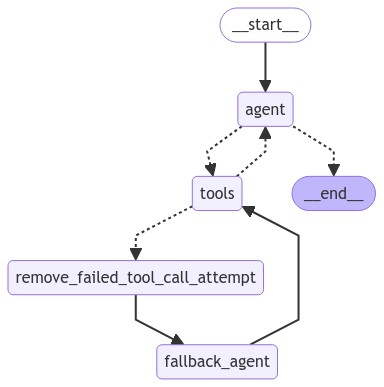

In [9]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's try it out. To emphasize the removal steps, let's `stream` the responses from the model so that we can see each executed node:

In [10]:
stream = app.stream(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10},
)

for chunk in stream:
    print(chunk)

{'agent': {'messages': [AIMessage(content=[{'text': 'Here is a haiku about water:', 'type': 'text'}, {'id': 'toolu_01DHSAkgSaCR1hrpAx1cKbJs', 'input': {'topic': ['water']}, 'name': 'master_haiku_generator', 'type': 'tool_use'}], response_metadata={'id': 'msg_015dn3iAZDnBxPCzDo8eWSub', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 384, 'output_tokens': 67}}, id='run-8b01a16f-1dcd-4d4b-b183-725f8e7a2865-0', tool_calls=[{'name': 'master_haiku_generator', 'args': {'topic': ['water']}, 'id': 'toolu_01DHSAkgSaCR1hrpAx1cKbJs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 384, 'output_tokens': 67, 'total_tokens': 451})]}}
{'tools': {'messages': [ToolMessage(content='', additional_kwargs={'error': ValidationError(model='master_haiku_generatorSchema', errors=[{'loc': ('request',), 'msg': 'field required', 'type': 'value_error.missing'}])}, name='master_haiku_generator', id='b4761ee1-4d73-482b-85a0-6c114463ab1d', tool_cal

/Users/vadymbarda/.virtualenvs/langgraph/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


{'fallback_agent': {'messages': [AIMessage(content=[{'text': 'Certainly! I\'d be happy to help you create an incredible haiku about water. To do this, I\'ll use the master_haiku_generator function, which requires three topics. Since you\'ve specified water as the main theme, I\'ll add two related concepts to create a more vivid and interesting haiku. Let\'s use "water," "flow," and "reflection" as our three topics.', 'type': 'text'}, {'id': 'toolu_01THSivCtMnx6P7oVy4eqywy', 'input': {'request': {'topic': ['water', 'flow', 'reflection']}}, 'name': 'master_haiku_generator', 'type': 'tool_use'}], response_metadata={'id': 'msg_01HQQbQ8YjSKn37kQYSwKn8D', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 414, 'output_tokens': 158}}, id='run-c0ceb996-d5f4-4d28-9844-095c83b74ebe-0', tool_calls=[{'name': 'master_haiku_generator', 'args': {'request': {'topic': ['water', 'flow', 'reflection']}}, 'id': 'toolu_01THSivCtMnx6P7oVy4eqywy

You can see that you get a cleaner response - the more powerful model gets it right on the first try, and the smaller model's failure gets wiped from the graph state. This shorter message history also avoid overpopulating the graph state with attempts.

You can also inspect this [LangSmith trace](https://smith.langchain.com/public/7ce6f1fe-48c4-400e-9cbe-1de2da6d2800/r), which shows the failed initial call to the smaller model.

## Next steps

You've now seen how to implement some strategies to handle tool calling errors.

Next, check out some of the [other LangGraph how-to guides here](https://langchain-ai.github.io/langgraph/how-tos/).